# imports:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from tqdm import tqdm

import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #for no tensorflow warnings"
sys.path.append(os.path.abspath('..'))

2022-02-17 21:38:00.385829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 21:38:00.385858: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from src import *
from models import *
from src.main import Cluster_Class, set_file_model, set_keras_model
from src.models import Keras_Model
from src.cluster_methods import SensitivityAnalysis
from src.data_utils import get_MNIST_data

In [3]:
import pickle
with open('MNIST_5x100_jacobian.pkl', 'rb') as f:
    all_jacobians = pickle.load(f)

# setup:

In [4]:
from sklearn.metrics.pairwise import cosine_distances
def pairwise_cosine_dist(A):
    D = cosine_distances(A)
    return D

def get_distances(jacobian):
    distances = {}
    for k in jacobian.keys():
        if k != 'in' and k != 'out':
            j = jacobian[k].T
            distances[k] = pairwise_cosine_dist(j)
    return distances

In [125]:
def load_model():
    def softmax_loss():        
        def loss(y_true, y_pred):
            y_soft = tf.keras.activations.softmax(y_pred, axis=1)
            loss_soft=keras.losses.SparseCategoricalCrossentropy()(y_true, y_soft)
            return loss_soft
        return loss
    model = tf.keras.models.load_model('MNIST_5x100.h5', custom_objects={'loss': softmax_loss()})
    return model

def cluster_new(distances, eps, rrs, IDX, verbose=True):
    def softmax_loss():        
        def loss(y_true, y_pred):
            y_soft = tf.keras.activations.softmax(y_pred, axis=1)
            loss_soft=keras.losses.SparseCategoricalCrossentropy()(y_true, y_soft)
            return loss_soft
        return loss
    model = tf.keras.models.load_model('MNIST_5x100.h5', custom_objects={'loss': softmax_loss()})
    
    m = set_keras_model(model)
    m.update_keras()
    print("model accuracy. ", m.test_accuracy(verbose=False))
    print("pre_acc: ", m.test_MNIST_labelacc(IDX))
    
    SA = SensitivityAnalysis(distances = distances, eps=eps, rrs=rrs)
    
    cc = Cluster_Class(m, [10], cl_method="gradients", test_method=SA)
    acc, dic = cc.perform_clustering(verbose=verbose)
    print(acc, dic)
    print("model accuracy on class {0}. ".format(IDX), m.test_MNIST_labelacc(IDX))
    m.update_keras()
    return m.model

# experiments:

In [94]:
IDX = 6
curr_jac = all_jacobians[IDX] #denoised_jacobian
for key in curr_jac.keys():
    curr_jac[key] -= np.amin(curr_jac[key])
    curr_jac[key] /= np.amax(curr_jac[key])
distances = get_distances(curr_jac)
print([(key, distances[key].shape) for key in distances.keys()])

[('d1', (100, 100)), ('d2', (100, 100)), ('d3', (100, 100)), ('d4', (100, 100)), ('d5', (100, 100))]


In [25]:
eps = {1: 1e-7, 2:1e-7, 3:1e-7, 4:1e-7, 5:1e-7}
rrs = {1: 0.0, 2:0.0, 3:0.0, 4:0.4, 5:0.4}

In [26]:
model = cluster_new(distances, IDX, eps, rrs)

model accuracy.  0.9764999747276306
pre_acc:  0.9670542478561401
Test set accuracy:  0.9764999747276306
----- [Get Activations] -----
----- [Start Clustering] -----
   - Layer 1
----- [Get Clusters] -----
using d1 with eps=1e-07
labels 
 ['-1:(100,)']
num neurons reduced=0
[]
   - Layer 2
----- [Get Clusters] -----
using d2 with eps=1e-07
labels 
 ['-1:(100,)']
num neurons reduced=0
[]
   - Layer 3
----- [Get Clusters] -----
using d3 with eps=1e-07
labels 
 ['-1:(100,)']
num neurons reduced=0
[]
   - Layer 4
----- [Get Clusters] -----
Binary Search started ...
     eps = 1.0, rr = 1.0
     eps = 0.5, rr = 1.0
     eps = 0.25, rr = 1.0
     eps = 0.125, rr = 1.0
     eps = 0.0625, rr = 1.0
     eps = 0.03125, rr = 0.78
     eps = 0.015625, rr = 0.17
     eps = 0.0234375, rr = 0.52
     eps = 0.01953125, rr = 0.38
     eps = 0.021484375, rr = 0.47
     eps = 0.0205078125, rr = 0.43
     eps = 0.02001953125, rr = 0.41
using d4 with eps=1e-07
labels 
 ['-1:(51,)', '0:(9,)', '1:(2,)', '2:(2

# experiment 1: is confustion matrix related to performance?

In [104]:
IDX = 5
curr_jac = all_jacobians[IDX] #denoised_jacobian
for key in curr_jac.keys():
    curr_jac[key] -= np.amin(curr_jac[key])
    curr_jac[key] /= np.amax(curr_jac[key])
distances = get_distances(curr_jac)
print([(key, distances[key].shape) for key in distances.keys()])

[('d1', (100, 100)), ('d2', (100, 100)), ('d3', (100, 100)), ('d4', (100, 100)), ('d5', (100, 100))]


In [105]:
def softmax_loss():        
    def loss(y_true, y_pred):
        y_soft = tf.keras.activations.softmax(y_pred, axis=1)
        loss_soft=keras.losses.SparseCategoricalCrossentropy()(y_true, y_soft)
        return loss_soft
    return loss
model = tf.keras.models.load_model('MNIST_5x100.h5', custom_objects={'loss': softmax_loss()})

In [106]:
from sklearn.metrics import confusion_matrix

data = get_MNIST_data()
y_test = data['y_test']
X_test = data['X_test']
y_pred = np.argmax(model(X_test), axis=1)

confusion = confusion_matrix(y_test, y_pred)

In [ ]:
rrs = {1: 0.0, 2:0.4, 3:0.4, 4:0.4, 5:0.4}
model = cluster_new(distances, IDX, eps, rrs, verbose=False)
y_pred_post = np.argmax(model(X_test), axis=1)
confusion_post = confusion_matrix(y_test, y_pred_post)
print(confusion_post)
print(confusion)

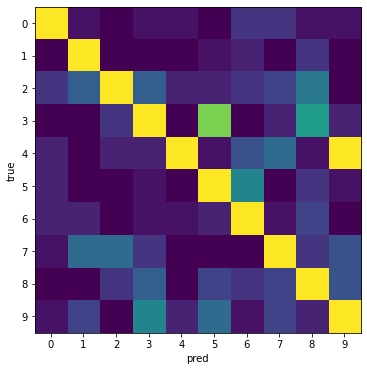

In [108]:
import matplotlib.pyplot as plt
plt.imshow(confusion, cmap='viridis', interpolation='nearest', vmin=0, vmax=20)

plt.xticks([i for i in range(confusion.shape[0])])
plt.yticks([i for i in range(confusion.shape[0])])
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

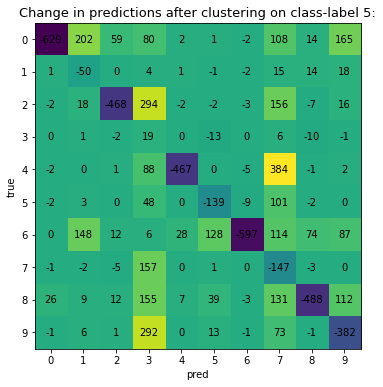

In [118]:
import matplotlib.pyplot as plt
result = confusion_post - confusion
plt.imshow(result, cmap='viridis', interpolation='nearest')
plt.rcParams["figure.figsize"] = (6,6)


for y in range(confusion.shape[0]):
    for x in range(confusion.shape[1]):
        plt.text(x, y, '%.0f' % result[y, x],  horizontalalignment='center',
                 verticalalignment='center',)

plt.xticks([i for i in range(confusion_post.shape[0])])
plt.yticks([i for i in range(confusion_post.shape[0])])
plt.xlabel('pred')
plt.ylabel('true')
plt.title('Change in predictions after clustering on class-label {0}:'.format(IDX), fontsize=13)
plt.show()

# experiment 2: clustering on multiple classes

## approach 1: combine jacobians "denoised"

In [126]:
sample = list(all_jacobians.values())[0]
curr_jac = {}

for layer in sample.keys():
    curr_jac[layer] = np.zeros(sample[layer].shape)
    for idx in all_jacobians.keys():   #class labels
        tmp = all_jacobians[idx][layer]
        curr_jac[layer][idx] = tmp[idx]
for key in curr_jac.keys():
    curr_jac[key] -= np.amin(curr_jac[key])
    curr_jac[key] /= np.amax(curr_jac[key])
    
distances = get_distances(curr_jac)
print([(key, distances[key].shape) for key in distances.keys()])

[('d1', (100, 100)), ('d2', (100, 100)), ('d3', (100, 100)), ('d4', (100, 100)), ('d5', (100, 100))]


## approach 2: average jacobians

In [143]:
sample = list(all_jacobians.values())[0]
curr_jac = {}

for layer in sample.keys():
    curr_jac[layer] = np.zeros(sample[layer].shape)
    for idx in all_jacobians.keys():   #class labels
        tmp = all_jacobians[idx][layer]
        curr_jac[layer] += tmp
for key in curr_jac.keys():
    curr_jac[key] -= np.amin(curr_jac[key])
    curr_jac[key] /= np.amax(curr_jac[key])
    
distances = get_distances(curr_jac)
print([(key, distances[key].shape) for key in distances.keys()])

[('d1', (100, 100)), ('d2', (100, 100)), ('d3', (100, 100)), ('d4', (100, 100)), ('d5', (100, 100))]


In [144]:
data = get_MNIST_data()
y_test = data['y_test']
X_test = data['X_test']
model=load_model()
y_pred = np.argmax(model(X_test), axis=1)

confusion = confusion_matrix(y_test, y_pred)

In [145]:
rrs = {1: 0.2, 2:0.2, 3:0.4, 4:0.4, 5:0.4}
model = cluster_new(distances, eps, rrs, IDX=0,verbose=False)

model accuracy.  0.9764999747276306
pre_acc:  0.9887754917144775
Binary Search started ...
     eps = 1.0, rr = 1.0
     eps = 0.5, rr = 1.0
     eps = 0.25, rr = 1.0
     eps = 0.125, rr = 1.0
     eps = 0.0625, rr = 1.0
     eps = 0.03125, rr = 0.98
     eps = 0.015625, rr = 0.86
     eps = 0.0078125, rr = 0.64
     eps = 0.00390625, rr = 0.25
     eps = 0.001953125, rr = 0.04
     eps = 0.0029296875, rr = 0.09
     eps = 0.00341796875, rr = 0.2
using d1 with eps=1e-07
labels 
 ['-1:(72,)', '0:(2,)', '1:(13,)', '2:(2,)', '3:(3,)', '4:(2,)', '5:(2,)', '6:(2,)', '7:(2,)']
num neurons reduced=20
Binary Search started ...
     eps = 1.0, rr = 1.0
     eps = 0.5, rr = 1.0
     eps = 0.25, rr = 1.0
     eps = 0.125, rr = 1.0
     eps = 0.0625, rr = 1.0
     eps = 0.03125, rr = 0.91
     eps = 0.015625, rr = 0.57
     eps = 0.0078125, rr = 0.19
using d2 with eps=1e-07
labels 
 ['-1:(75,)', '0:(4,)', '1:(3,)', '2:(10,)', '3:(2,)', '4:(2,)', '5:(4,)']
num neurons reduced=19
Binary Search star

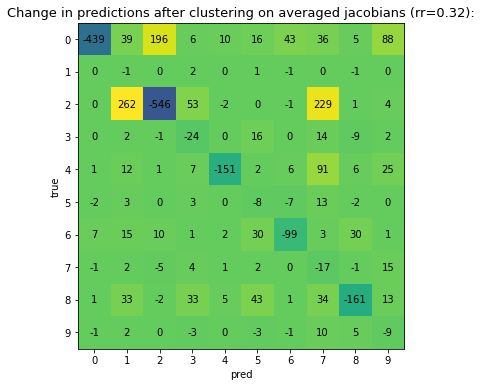

In [148]:
import matplotlib.pyplot as plt

y_pred_post = np.argmax(model(X_test), axis=1)
confusion_post = confusion_matrix(y_test, y_pred_post)

result = confusion_post - confusion
vmin_ = np.min(result)
plt.imshow(result, cmap='viridis', interpolation='nearest', vmin=vmin_-300)
plt.rcParams["figure.figsize"] = (6,6)


for y in range(confusion.shape[0]):
    for x in range(confusion.shape[1]):
        plt.text(x, y, '%.0f' % result[y, x],  horizontalalignment='center',
                 verticalalignment='center',)

plt.xticks([i for i in range(confusion_post.shape[0])])
plt.yticks([i for i in range(confusion_post.shape[0])])
plt.xlabel('pred')
plt.ylabel('true')
plt.title('Change in predictions after clustering on averaged jacobians (rr={0}):'.format(0.32), fontsize=13)
plt.show()

# old code: